In [14]:

from __future__ import division
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import control
import control.matlab as mlab
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as sla
import scipy.integrate as integrate
from sympy import Matrix
import numpy.linalg as la
import matplotlib as mpl


## Edit this so that you are pointing to where you keep the utils folder which has in it _547utils.py
import sys
sys.path.insert(0, '/Users/ratlifflj/repos/teach/2022/W22-547/src/jpyntbks/')
from utils._547utils import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=2)
lw=4
fs=20

import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stability of Linear Systems
### Continuous Time 
Recall from class that we say a system is stable if for any positive definite symmetric $Q$, there exists a unique $P$ which solves
$$AP+PA^\top=-Q$$

In [15]:
n=4
np.random.seed(2)
A=np.random.rand(n,n)-2*np.eye(n)
print("A:\n", A)
print("eig(A):\n", np.linalg.eig(A)[0])
print("")
Q=-PSD(n, seed=None)
P=sla.solve_lyapunov(A,Q)
print("P:\n",P)
print("")
print('is symmetric?:',np.allclose(P,P.T, rtol=1e-3))
print('')
if np.all(np.linalg.eig(P)[0]>0):
    print('is PD?  :   True')
    print('eigs(P) :  ', np.linalg.eig(P)[0])

A:
 [[-1.56  0.03  0.55  0.44]
 [ 0.42 -1.67  0.2   0.62]
 [ 0.3   0.27 -1.38  0.53]
 [ 0.13  0.51  0.18 -1.21]]
eig(A):
 [-0.4 +0.j   -1.92+0.14j -1.92-0.14j -1.58+0.j  ]

P:
 [[0.88 0.54 0.92 0.47]
 [0.54 0.64 0.66 0.52]
 [0.92 0.66 1.32 0.75]
 [0.47 0.52 0.75 2.4 ]]

is symmetric?: True

is PD?  :   True
eigs(P) :   [3.44 1.41 0.15 0.24]


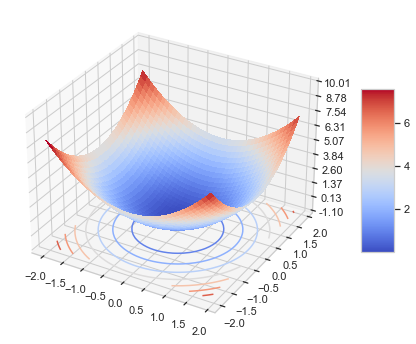

In [16]:
## Surface and Contour plot of v(x)=x^TPx, P=I
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.1, 10.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
cset = ax.contour(X, Y, Z, zdir='z', offset=-1, cmap=cm.coolwarm)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Discrete time
In discrete time, recall that to check if $A$ is stable, given a positive definite $Q$, we need to find a positive definite symmetric solution $P$ to
$$A^\top PA-P=-Q$$

In [17]:
# Change the seed values if you want to explore different examples
np.random.seed(3)
A=np.random.normal(0,0.5, size=(n,n))-0.1*np.eye(n)
print("A:\n",A)
print("")
print('eig(A) : ', la.eig(A)[0])
print('inside unit circle? :', np.all(np.array([la.norm(e) for e in np.linalg.eig(A)[0]])<1))
print("")
Q=PSD(n, seed=None)
print("Q :\n", Q)

P=sla.solve_discrete_lyapunov(A,Q)
print("P:\n",P)
psdP=False
if np.all(la.eig(P)[0]>0) and np.allclose(P,P.T, rtol=1e-3):
    psdP=True
print(la.eig(P)[0])
print('is PSD?: ', psdP)

A:
 [[ 0.79  0.22  0.05 -0.93]
 [-0.14 -0.28 -0.04 -0.31]
 [-0.02 -0.24 -0.76  0.44]
 [ 0.44  0.85  0.03 -0.3 ]]

eig(A) :  [ 0.51+0.j   -0.13+0.68j -0.13-0.68j -0.79+0.j  ]
inside unit circle? : True

Q :
 [[ 3.22  0.85 -0.68 -0.79]
 [ 0.85  2.57  0.24  0.91]
 [-0.68  0.24  1.34  0.43]
 [-0.79  0.91  0.43  4.22]]
P:
 [[13.75  1.27 -2.41  5.67]
 [ 1.27  4.72 -1.46 -0.64]
 [-2.41 -1.46  7.13  0.24]
 [ 5.67 -0.64  0.24 11.  ]]
[18.54+0.j  9.13+0.j  5.03+0.j  3.9 +0.j]
is PSD?:  True


### Nonlinear Pendulum Example
Recall the pendulum example. The dynamics are
$$\begin{array}{ll} \dot{\theta}&=\phi\\
\dot{\phi}&=-\frac{g}{\ell}\sin(\theta)\end{array}$$
The critical points are at $(k\pi,0)$, $k\in \mathbb{Z}$. If $k$ is odd the critical points are hyperbolic, meaning that the Jacobian has eigenvalues with non-zero real part. On the other hand, if $k$ is even, then the critical points are non-hyperbolic meaning the Jacobian has eigenvalues that are purely imaginary.  Therefore, Hartman’s theorem (mentioned in class) cannot
be applied when $k$ is even.

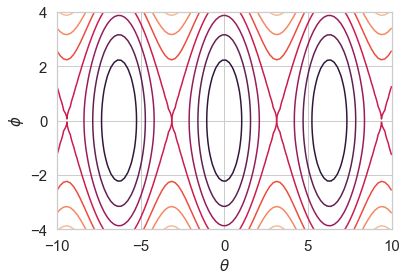

In [18]:
## solution curves 
xlist = np.linspace(-10.0, 10.0, 100)
ylist = np.linspace(-4.0, 4.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = Y ** 2 / 2 - 5 * np.cos(1*X) # hamiltonian of the system is phi^2/2-g/l*cos(theta) 
plt.figure()
plt.contour(X, Y, Z)
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\phi$', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

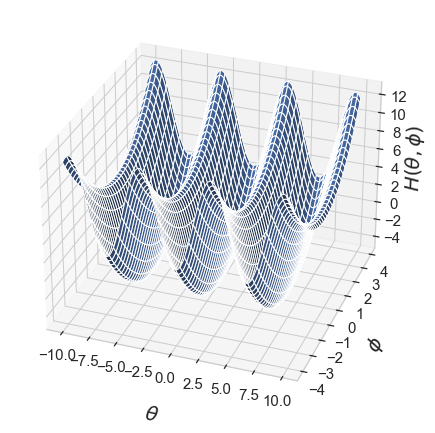

In [19]:
# surface plot of the hamiltonian
def fun(x, y):
    return y **2/2-5* np.cos(x)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection = '3d')
x = np.arange(-10.0, 10.0, 0.1)
y = np.arange(-4.0, 4.0, 0.1)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$\phi$', fontsize=20)
ax.set_zlabel(r'$H(\theta,\phi)$', fontsize=20)
ax.yaxis.labelpad=12
ax.xaxis.labelpad=20
plt.tight_layout()
plt.tick_params(labelsize=15)
ax.view_init(30, -70)
plt.show()

In [20]:
g,l,m = 9.81,.5,1. # m/sec^2, m, kg

def f(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a) + (1/m)*u])

def f_(t,x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a)])

def h(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return a # output only the angle

### PD Feedback Controller
Recall from a previous notebook that we simulated the system with a PD controller. This is an example of a state feedback controller since
$$u(t)=Kx=\begin{bmatrix} -k_p & - k_d\end{bmatrix}\begin{bmatrix} \theta\\ \phi\end{bmatrix}$$

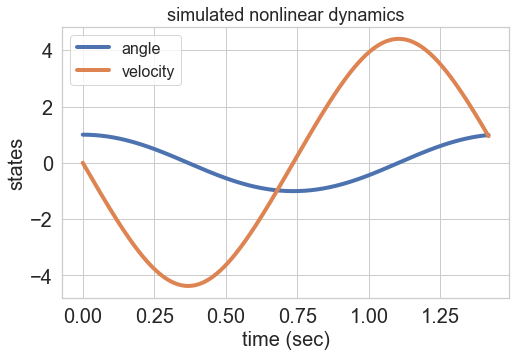

In [21]:
dt = 1e-3 
t1 = 1 * 2*np.pi*np.sqrt(l/g) 
x0 = [1.,0.] # "interesting" initial condition


kp,kd = 1.,0.
u1 = lambda t,x : -kp*x[0] - kd*x[1] # PD controller
sim=forward_euler
t_,x_ = sim(f,t1,x0,dt=dt,utx=u1)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]
plt.figure(figsize=(8,5))
arrayPLT=plt.plot(t_,x_,'-', linewidth=lw)
plt.xlabel('time (sec)', fontsize=fs)
plt.ylabel('states', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.title('simulated nonlinear dynamics', fontsize=18)
plt.legend(iter(arrayPLT), ('angle', 'velocity'), fontsize=16)

In [22]:
# Get linearized dynamics
def Dxf(x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([[0.,1.],[-(g/l)*np.cos(a),0.]])

def Duf(x):
    return np.array([[0],[1]])

def Dxh(x):
    return np.array([[1, 0]])

By checking the eigenvalues of the closed loop linearized dynamics, we see that the PD controller stabilizes the system.

In [23]:
xe=np.array([2*np.pi,0])
A=Dxf(xe)
B=Duf(xe)
print("Linearized Dynamics: \n", "A:\n",A,"\n B: \n", B)
print('eig(A) : ', la.eig(A)[0])
print("")
kp=0.; kd=1
K=np.array([[-kp,-kd]])
Acl=A+B@K
print('Closed loop dynamics A+BK: \n', Acl)
print('eig(A+BK): ', la.eig(Acl)[0])

Linearized Dynamics: 
 A:
 [[  0.     1.  ]
 [-19.62   0.  ]] 
 B: 
 [[0]
 [1]]
eig(A) :  [0.+4.43j 0.-4.43j]

Closed loop dynamics A+BK: 
 [[  0.     1.  ]
 [-19.62  -1.  ]]
eig(A+BK):  [-0.5+4.4j -0.5-4.4j]


Text(0, 0.5, 'control')

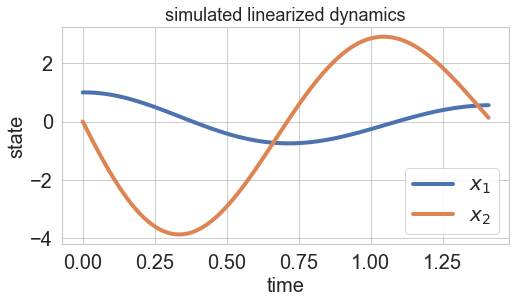

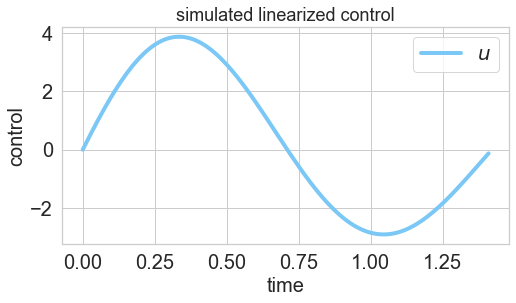

In [25]:
f_lin=lambda t,x: Acl@x
t_lin,x_lin=forward_euler(f_lin,t1,x0,t0=0.,dt=1e-2)
plt.figure(figsize=(8,4))

plt.plot(t_lin,x_lin[:,0], label=r'$x_1$', linewidth=4)
plt.plot(t_lin,x_lin[:,1], label=r'$x_2$', linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.title("simulated linearized dynamics", fontsize=18)
plt.xlabel('time', fontsize=20)
plt.ylabel('state', fontsize=20)
u_lin=[]
for x_ in x_lin:
    u_lin.append(K@x_)
plt.figure(figsize=(8,4))

plt.plot(t_lin,u_lin, label=r'$u$', linewidth=4, color='xkcd:lightblue')
plt.title("simulated linearized control", fontsize=18)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('control', fontsize=20)

In [26]:
u_lin=np.asarray(u_lin)
# approximate integral cost over time horizon [0,t1]
print('final time       : % 1.3f'% t1)
print('approximate cost : ', sum(u_lin*u_lin*dt))

final time       :  1.419
approximate cost :  [0.83]


## Assessing Performance 
Recell from class that we said we could assess performance measures by using the Lyapunov equation to evaluate integral performance metrics such as energy of the input and energy of the output:
$$J_u=\int_0^\infty u(t)^\top u(t)\ dt, \quad J_y=\int_0^\infty y(t)^\top y(t)\ dt$$
Recall that to evaluate these performance metrics we need to solve
$$(A+BK)^\top P_u+P_u(A+BK)+K^\top K=0$$
and
$$(A+BK)^\top P_y+P_y(A+BK)+C^\top C=0,$$
respectively, where $C=D_xh(x_e)=\begin{bmatrix} 1 & 0\end{bmatrix}$.

In [27]:
C=Dxh(xe)
Pu=sla.solve_continuous_lyapunov((A+B@K).T,-K.T@K) # Note the transpose on A! it took me a while to figure out why I was not getting the integral cost to match up
Py=sla.solve_lyapunov((A+B@K).T,-C.T@C)
Px=sla.solve_lyapunov((A+B@K).T, -np.eye(2)) # just checking the closed loop state energy cost as well
print('Pu :\n ',Pu)
print('eig(Pu) :  ', la.eig(Pu)[0])
print("")
print('Py :\n ',Py)
print('eig(Py) :  ', la.eig(Py)[0])
print("")
print('Px :\n ',Px)
print('eig(Px) :  ', la.eig(Px)[0])
print("")
x0_=np.asarray(x0)
Ju=x0_.T@Pu@x0_
print("control cost :  %.3f"% Ju)
Jy=x0_.T@Py@x0_
print("output  cost :  %.3f"% Jy)
Jx=x0_.T@Px@x0_
print("state  cost :  %.3f"% Jx)

Pu :
  [[9.81e+00 4.05e-17]
 [1.36e-17 5.00e-01]]
eig(Pu) :   [9.81+0.j 0.5 +0.j]

Py :
  [[0.53 0.03]
 [0.03 0.03]]
eig(Py) :   [0.53+0.j 0.02+0.j]

Px :
  [[10.34  0.03]
 [ 0.03  0.53]]
eig(Px) :   [10.34+0.j  0.53+0.j]

control cost :  9.810
output  cost :  0.525
state  cost :  10.335


We can check this is correct by noting that
$$J_u=\int_0^\infty u(t)^\top u(t)\ dt=\int_0^\infty x_0^\top e^{A^\top (t-t_0)}\underbrace{K^\top K}_{"Q"}e^{A (t-t_0)}x_0\ dt$$

In [28]:
gu=lambda tv: x0_.T@sla.expm(Acl.T*tv)@K.T@K@sla.expm(Acl*tv)@x0_
gy=lambda tv: x0_.T@sla.expm(Acl.T*tv)@C.T@C@sla.expm(Acl*tv)@x0_
gx=lambda tv: x0_.T@sla.expm(Acl.T*tv)@sla.expm(Acl*tv)@x0_

In [29]:
print(" Checking the control cost: ")
print('integral value, error value: (%.3f, %.3f))'% integrate.quad(gu,0, np.infty))

Pu=sla.solve_continuous_lyapunov((A+B@K).T, -K.T@K)
Ju=x0_.T@Pu@x0_
print("control  cost :  %.3f"% Ju)
print("")

print(" Checking the output cost: ")
print('integral value, error value: (%.3f, %.3f))'% integrate.quad(gy,0, np.infty))

Py=sla.solve_continuous_lyapunov((A+B@K).T,-C.T@C)
Jy=x0_.T@Py@x0_
print("state  cost :  %.3f"% Jy)
print("")

print(" Checking the state cost: ")
print('integral value, error value: (%.3f, %.3f))'% integrate.quad(gx,0, np.infty))

Px=sla.solve_continuous_lyapunov((A+B@K).T,-np.eye(2))
Jx=x0_.T@Px@x0_
print("state  cost :  %.3f"% Jx)

 Checking the control cost: 
integral value, error value: (9.810, 0.000))
control  cost :  9.810

 Checking the output cost: 
integral value, error value: (0.525, 0.000))
state  cost :  0.525

 Checking the state cost: 
integral value, error value: (10.335, 0.000))
state  cost :  10.335


## Next Up: Can we design an input to stabilize?
After we talk about controllability, we will introduce the notion of stabilizability and how to leverage Lyapunov theory to design feedback stabilizing controller.